# 영업이익과 당기순이익의 상태에 따라 투자했을 때의 기대수익 비교

In [2]:
# 데이터 준비

import pandas as pd

cols = ["기업", "연도", "현재_주가", "미래_주가", "영업이익_상태", "당기순이익_상태"]
data = pd.read_csv("data/재무제표_분석용데이터.csv", usecols=cols, encoding="euc-kr")

In [3]:
# 결측치는 제거
data.dropna(inplace=True)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

In [6]:
# 상태 변수 분포 확인

print(data["영업이익_상태"].value_counts(normalize=True))
print(data["당기순이익_상태"].value_counts(normalize=True))

# 두 컬럼 모두 흑자지속-적자지속-적자전환-흑자전환 순으로 빈도가 높음

흑자지속    0.656179
적자지속    0.145142
흑자전환    0.100817
적자전환    0.097862
Name: 영업이익_상태, dtype: float64
흑자지속    0.564401
적자지속    0.192856
흑자전환    0.122371
적자전환    0.120372
Name: 당기순이익_상태, dtype: float64


Text(0, 0.5, '수익률')

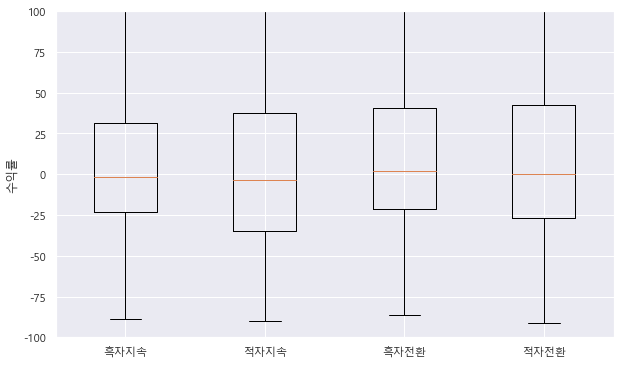

In [7]:
# 영업이익 상태에 따르 수익률 시각화

data["수익률"] = (data["미래_주가"]-data["현재_주가"]) / data["현재_주가"]*100

plt.figure(figsize=(10, 6))
graph_data = []

for state in ["흑자지속", "적자지속", "흑자전환", "적자전환"]:
    value = data.loc[data["영업이익_상태"]==state, "수익률"]
    graph_data.append(value)

plt.boxplot(graph_data)
plt.ylim(-100, 100)
plt.xticks([1, 2, 3, 4], ["흑자지속", "적자지속", "흑자전환", "적자전환"])
plt.ylabel("수익률")

# 흑자전환일 때 박스가 가장 높게 위치하고 적자지속일때 아랫쪽에 위치하나, 완벽하게 선형관계인것은 아님

Text(0, 0.5, '수익률')

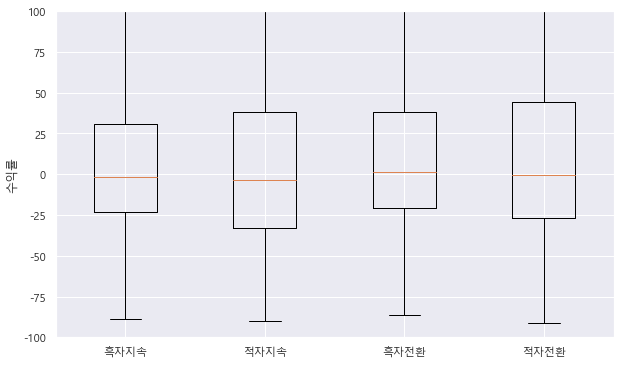

In [8]:
# 당기순이익 상태에 따르 수익률 시각화

plt.figure(figsize=(10, 6))
graph_data = []

for state in ["흑자지속", "적자지속", "흑자전환", "적자전환"]:
    value = data.loc[data["당기순이익_상태"]==state, "수익률"]
    graph_data.append(value)

plt.boxplot(graph_data)
plt.ylim(-100, 100)
plt.xticks([1, 2, 3, 4], ["흑자지속", "적자지속", "흑자전환", "적자전환"])
plt.ylabel("수익률")

# 영업이익-수익률 분포는 당기순이익-수익률 분포와 비슷함

In [9]:
# 상태에 따른 수익률 통계량

print(data.groupby(["영업이익_상태"])["수익률"].describe().round(2))

# 흑자 전환의 평균, 1, 3분위수, 중간값이 다른값보다 높으며, 특히 중간값이 양수인데 이는 투자하면 반 이상이 2.34%의 수익을 얻을 수 있다는 의미
# 적, 흑자를 가리지 않고 지속되는 경우보다 전환된 경우의 기대수익이 더 높음

          count   mean     std    min    25%   50%    75%      max
영업이익_상태                                                           
적자전환     1126.0  21.61   85.27 -91.53 -27.12  0.00  42.39   763.73
적자지속     1670.0  19.03  102.25 -89.87 -34.69 -3.30  37.42  1863.16
흑자전환     1160.0  26.87   98.92 -86.09 -21.23  2.08  40.41  1603.51
흑자지속     7550.0  15.16   69.86 -89.08 -23.23 -1.86  31.55  2202.02


In [10]:
print(data.groupby(["당기순이익_상태"])["수익률"].describe().round(2))

# 영업이익과 동일하지만 기대수익은 더 낮으므로 영업이익을 기준으로 투자하는게 더 나음

           count   mean     std    min    25%   50%    75%      max
당기순이익_상태                                                           
적자전환      1385.0  21.31   80.02 -91.53 -26.54 -0.62  44.03   579.64
적자지속      2219.0  20.07  105.24 -89.87 -32.85 -3.30  37.91  1863.16
흑자전환      1408.0  23.32   80.56 -86.09 -20.41  1.63  38.45  1066.29
흑자지속      6494.0  14.60   69.41 -89.08 -22.93 -1.87  30.74  2202.02


## 동일 가중 교체 매매 방법
* 매수 기준을 흑자전환인 종목으로 매수하고, 다음 공시때 흑자전환인 종목으로 보유종목을 교체하는 방법 like 리밸런싱
* 영업이익 상태를 기준으로 수익률 계산

In [11]:
result = []

for year in range(2014, 2020):
    y_data = data.loc[data['연도'] == year]
    for state in ["흑자지속", "적자지속", "흑자전환", "적자전환"]:
        # 영업이익 상태와 연도에 따른 수익률 정의
        ror_list = y_data.loc[data["영업이익_상태"] == state, "수익률"]
        inve_per_stock = 10 ** 8 / len(ror_list) # 종목별 투자금 계산
        profit = (inve_per_stock * ror_list / 100).sum()
        profit_ratio = profit / 10 ** 8 * 100
        result.append([year, state, profit_ratio])

result = pd.DataFrame(result, columns = ["연도", "상태", "수익률"])

      count   mean    std    min    25%    50%    75%     max
상태                                                           
적자전환    6.0  16.96  44.35 -25.07 -10.27  10.60  19.97   99.78
적자지속    6.0  18.79  38.56 -23.00 -10.05  17.41  33.49   81.26
흑자전환    6.0  21.75  43.60 -18.40  -2.55  10.32  25.78  104.18
흑자지속    6.0  14.79  40.33 -23.90  -2.61   7.13  10.31   92.85


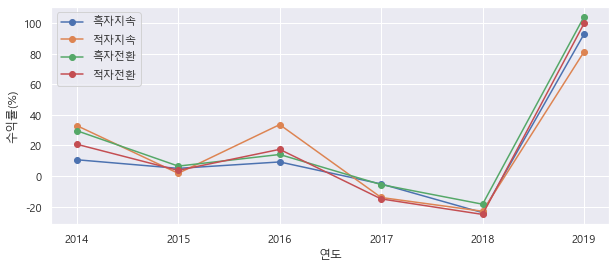

In [13]:
plt.figure(figsize = (10, 4))

for state in ["흑자지속", "적자지속", "흑자전환", "적자전환"]:
    graph_data = result.loc[(result['상태'] ==  state), '수익률'].values
    plt.plot(graph_data, marker = "o", label = state)

plt.xticks(range(6), range(2014, 2020))
plt.legend()
plt.ylabel("수익률(%)")
plt.xlabel("연도")

print(result.groupby('상태')['수익률'].describe().round(2))

# 흑자전환 - 적자전환 - 흑자지속 - 적자지속 순으로 수익률이 높음
# 적자지속의 중위수, 3분위수가 다른 경우보다 더 높음. 이는 적자지속을 기준으로 매매하면 가장 높은 수익률을 노려볼 수 있지만 그만큼 손해도 클 수 있다는 의미. 그래프상으로도 2016년 적자지속의 수익률이 제일 높음.
# 예상으로, 적자가 지속되어 저평가된 기업 구매 -> 높은 주가 상승폭을 통한 수익이 존재하기 때문이 아닐까 싶음.

In [14]:
# 당기순이익 상태를 기준으로 수익률 계산

result = []

for year in range(2014, 2020):
    y_data = data.loc[data['연도'] == year]
    for state in ["흑자지속", "적자지속", "흑자전환", "적자전환"]:
        # 당기순이익 상태와 연도에 따른 수익률 정의
        ror_list = y_data.loc[data["당기순이익_상태"] == state, "수익률"]
        inve_per_stock = 10 ** 8 / len(ror_list) # 종목별 투자금 계산
        profit = (inve_per_stock * ror_list / 100).sum()
        profit_ratio = profit / 10 ** 8 * 100
        result.append([year, state, profit_ratio])

result = pd.DataFrame(result, columns = ["연도", "상태", "수익률"])

      count   mean    std    min   25%    50%    75%     max
상태                                                          
적자전환    6.0  16.84  43.63 -26.79 -8.32  10.14  20.70   97.80
적자지속    6.0  18.07  40.35 -24.34 -9.49  12.16  31.47   87.24
흑자전환    6.0  21.43  45.44 -18.41 -2.22  10.54  19.78  109.54
흑자지속    6.0  14.38  39.16 -23.29 -2.29   7.65   9.19   90.20


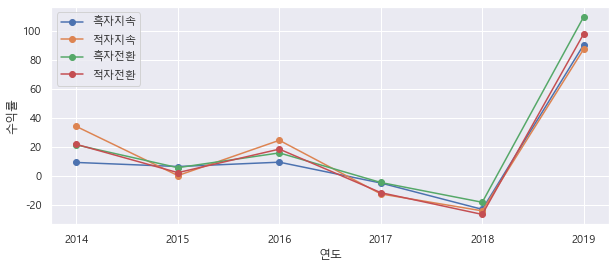

In [17]:
plt.figure(figsize = (10, 4))

for state in ["흑자지속", "적자지속", "흑자전환", "적자전환"]:
    graph_data = result.loc[(result['상태'] ==  state), '수익률'].values
    plt.plot(graph_data, marker = "o", label = state)

plt.xticks(range(6), range(2014, 2020))
plt.legend()
plt.ylabel("수익률")
plt.xlabel("연도")

print(result.groupby('상태')['수익률'].describe().round(2))

# 영업이익을 기준으로 할때와 동일한 결과. 통계 수치도 비슷함